In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import time

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator

### dataset설정

In [2]:
BUFFER_SIZE = 400  # 일정하게 랜덤값이 나오도록 하는 변수
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [3]:
# image load
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)
    
    rgb_image = tf.cast(image, tf.float32)
    
    return rgb_image

In [4]:
inp= load("./train/train/2018.jpg")
print(inp.shape)

(481, 321, 3)


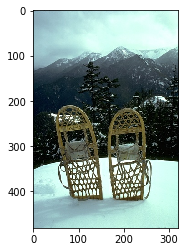

In [5]:
# 이미지 예시
plt.figure()
plt.imshow(inp/255.0)

In [6]:
# image resize 함수 생성
def resize(rgb_image, height, width):
    rgb_image = tf.image.resize(rgb_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return rgb_image

In [7]:
# 다양한 이미지를 생성하기 위해 crop 함수를 설정
def random_crop(rgb_image, height, width):
    cropped_image = tf.image.random_crop(
      rgb_image, size=[height, width, 3])

    return cropped_image

In [8]:
# normalizing the images to [-1, 1]

def normalize(rgb_image):
    rgb_image = (rgb_image / 127.5) - 1

    return rgb_image

In [9]:
# 무작위로 랜덤 이미지 생성
def random_jitter(rgb_image):
    # resizing to 286 x 286 x 3
    rgb_image = resize(rgb_image, 286, 286)
    
    # randomly cropping to 256 x 256 x 3
    rgb_image = random_crop(rgb_image, 256, 256)
    
    if tf.random.uniform(()) > 0.5:
        # random mirroring
        rgb_image = tf.image.flip_left_right(rgb_image)
    return rgb_image

In [10]:
# 데이터 구축을 위한 함수 종합

def load_image_train(image_file):
    rgb_image = load(image_file)
    rgb_image = random_jitter(rgb_image)
    gray_image = tf.image.rgb_to_grayscale(rgb_image)
    rgb_image = normalize(rgb_image)
    gray_image = normalize(gray_image)
    
    return gray_image, rgb_image

def load_image_test(image_file):
    rgb_image = load(image_file)
    rgb_image = resize(rgb_image, IMG_HEIGHT, IMG_WIDTH)
    gray_image = tf.image.rgb_to_grayscale(rgb_image)
    rgb_image = normalize(rgb_image)
    gray_image = normalize(gray_image)
    
    return gray_image, rgb_image

In [11]:
# load_image_train("./train/train/2018.jpg")

### Input Pipeline

In [12]:
# pipeline을 만들어서 데이터 구축
train_dataset = tf.data.Dataset.list_files("./train/train/*.jpg")
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [13]:
test_dataset = tf.data.Dataset.list_files("./test/test/*.jpg")
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

### Generator 생성
* Generator는 U-Net로 구성
* Encoder는 Conv->BatchNorm->LeakyRelu로 구성
* Decoder는 TransposeConv->Batchnorm->Dropout(처음 3개의 block만 적용)->ReLU로 구성
* skip connection으로 구성

In [14]:
OUTPUT_CHANNELS = 3  # 출력 채널 크기

In [15]:
# encoder 구성을 위한 모델 생성
def downsample(filters, kernel_size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, kernel_size, strides=2, padding='same',
                                     kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

In [16]:
# decoder 구성을 위한 모델 생성
def upsample(filters, kernel_size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=2, padding='same',
                                     kernel_initializer=initializer, use_bias=False))
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        
    result.add(tf.keras.layers.ReLU())
    
    return result

In [17]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256,256,3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]
    
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)
    
    x = inputs
    skips = []
    
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

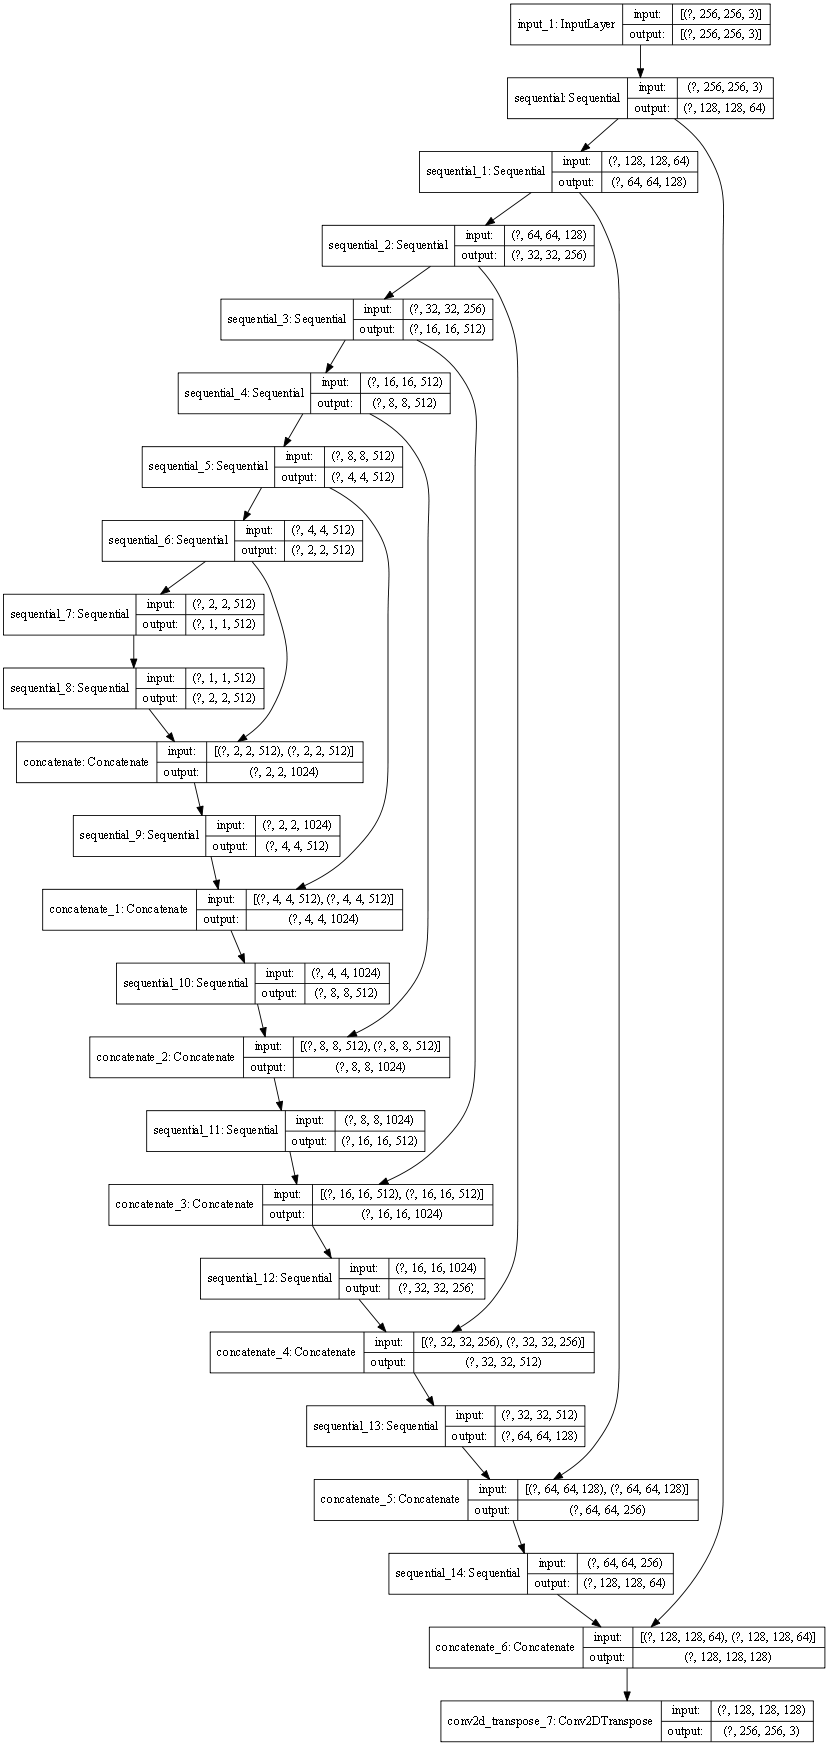

In [18]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


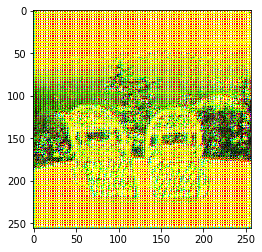

In [19]:
gen_output = generator(resize(inp[tf.newaxis,...], IMG_HEIGHT, IMG_WIDTH), training=False)
plt.imshow(gen_output[0, ...])

### Generator loss
* loss는 `L1`loss와 MAE를 사용한다.
* total generator loss = gan_loss + LAMBDA*L1 loss 이며 LAMBDA=100으로 paper에 설정되어 있다.

In [20]:
LAMBDA = 100

In [21]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), tf.zeros_like(disce_generated_output))
    
    # MAE
    l1_loss = tf.reduce_mean(tf.abs(target-gen_output))
    
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    
    return total_gen_loss, gan_loss, l1_loss

### Discriminator 구현
* PatchGAN으로 구현됨
* 각 block는 Conv -> BatchNorm -> Leaky ReLU로 구성
* 최종 결과값은 (batch_size, 30, 30, 1) 크기
* 총 2개의 inputs을 받음
  * input image와 target image(정답)
  * input image와 generated image
  * 해당 모델에서는 2개의 input을 concatenate하여 사용

In [22]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_shape')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
    
    x = tf.keras.layers.concatenate([inp, tar])  # (None, 256, 256, channels*2)
    
    down1 = downsample(64, 4, False)(x) # (None, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (None, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

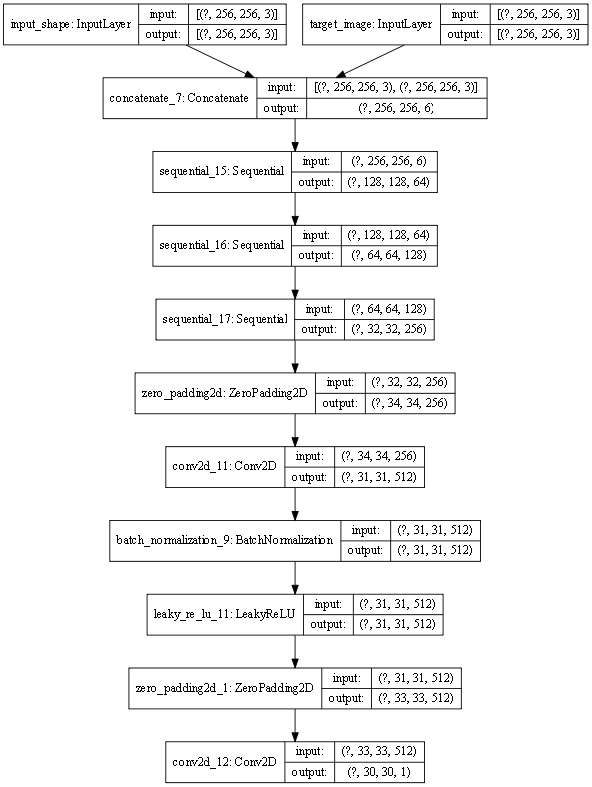

In [23]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

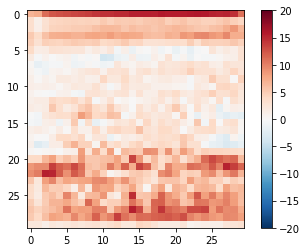

In [26]:
inp_resize = resize(inp, IMG_HEIGHT, IMG_WIDTH)
disc_out = discriminator([inp_resize[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()